In [22]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

In [23]:

with open(r"..\forecast\plan_a\data\market_simulator_1.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_2.json", "r") as f:
    test_data = json.loads(f.read())

In [24]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [27]:
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    return (x-m) / s

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    return (x-mmin) / (mmax-mmin)
    
    
    

In [76]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

In [95]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
# p = MLPRegressor(
#     hidden_layer_sizes=[50,50,50,50],
#     activation="relu"
# )
p = SVR(
    # kernel="poly"
)
p.fit(
    zscored_t[:,:16],
    zscored_t[:,16]
)

SVR()

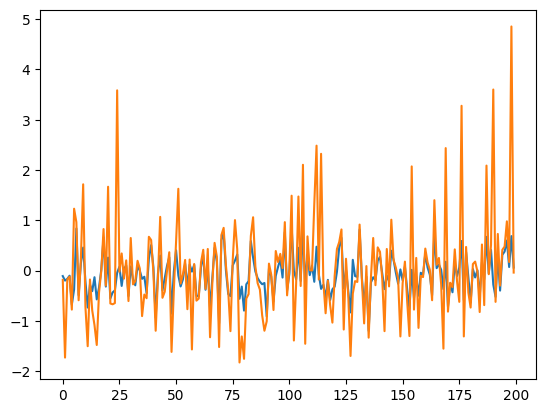

In [96]:
pyplot.plot(p.predict(zscored_t[:,:16]))
pyplot.plot(zscored_t[:,16])

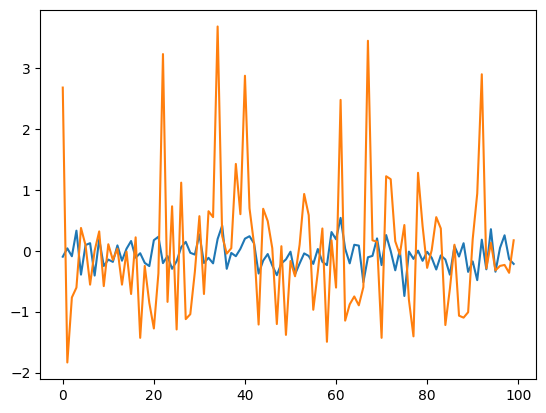

In [97]:
pyplot.plot(p.predict(zscored_x[:,:16]))
pyplot.plot(zscored_x[:,16])

In [98]:
p.score(zscored_x[:,:16], zscored_x[:,16])

0.028933250580337133